# Simulate a user accessing scenes to estimate # of sectors needed to unseal

## Imports

In [87]:
%matplotlib inline
import random
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# pd.options.display.max_rows = 999
import folium

## User Settings

In [59]:
number_of_requests = 1000
iterations = 5

## Sector and Cache Settings

In [60]:
# cache_time = 1000 # Number of requests (loops) before hot storage cache is cleared
# cache_hit_count = 0
sector_scene_count = 25
sector_packing_method = ""

## Prepare Landsat scenes (Rows/Paths) of the US

### Fetch files

[Landsat Descending Path/Row shapefile](https://www.usgs.gov/media/files/landsat-wrs-2-descending-path-row-shapefile)

[US States boundaries 20m:1 shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

[MSA boundaries 20m:1 shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

In [61]:
landsat_scenes_shp = gpd.read_file("https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip")[["PATH", "ROW", "geometry"]]
us_states_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")[["geometry", "STUSPS"]]
us_counties_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip")[["geometry", "STATEFP", "COUNTYFP"]]
us_regions = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_region_20m.zip")[["geometry", "NAME"]]
# h3_hexagons_shp = gpd.read_file("https://opendata.arcgis.com/datasets/4b9d6b8c3f3f4c5e8c7f8a4f4d8e7a7c_0.geojson")
msa_boundaries = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_csa_20m.zip")[["CSAFP", "geometry"]]

geometries = [us_states_shp, us_counties_shp, us_regions, msa_boundaries, landsat_scenes_shp]

# Reproject to WGS84
for geometry in geometries:
    geometry = geometry.to_crs("EPSG:4326", inplace=True)

In [100]:
len(us_counties_shp)

3220

### Clip Scenes and geometries to continental US

In [62]:
us_states_continential = us_states_shp[us_states_shp["STUSPS"].isin(["AK", "HI", "PR", "VI", "GU", "AS", "MP", "UM"]) == False] # Remove non-continental US states
geometries_clipped = []
for geometry in geometries:
    geometry = gpd.clip(geometry, us_states_continential)
    geometry.reset_index(inplace=True, drop=True) # Reset index since we removed some rows
    geometries_clipped.append(geometry)

/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

In [63]:
geometries_clipped[1].head()

,geometry,STATEFP,COUNTYFP
0,"POLYGON ((-76.58599 42.54991, -76.66654 42.623...",36,109
1,"POLYGON ((-71.80539 42.70891, -71.74582 42.707...",25,017
2,"POLYGON ((-75.42867 42.74542, -75.29588 42.744...",36,017
3,"POLYGON ((-72.93026 42.73907, -72.86429 42.737...",25,011
4,"POLYGON ((-74.66751 42.75071, -74.64830 42.829...",36,095


## Pack Sectors (nearest neighbors, sequential)

In [64]:
landsat_scenes_clipped_with_sectors = geometries_clipped[-1].copy()
scenes = landsat_scenes_clipped_with_sectors[["PATH", "ROW"]].sort_values(by=["PATH", "ROW"]).values

def array_present_in_array(array, array_to_check):
    """Check if an array is present in another array"""
    if (array == array_to_check).all(1).any():
        return True

car_scenes = {}

curr_indx = 0
 # While there are still scenes to be assigned to sectors
while len(scenes) > 0:
    current_sector = f"Sector {curr_indx}"
    if len(scenes) < sector_scene_count:
        car_scenes[current_sector] = scenes
        break

    tree = KDTree(scenes)
    scene_to_query = scenes[0]
    nearest_scene_indices = tree.query(scene_to_query, k=25)[1]
    nearest_scenes = scenes[nearest_scene_indices]

    car_scenes[current_sector] = nearest_scenes
    # Remove the scenes that were assigned to the sector
    scenes = np.delete(scenes, nearest_scene_indices, axis=0)
    curr_indx += 1

## Pack the sectors (Naive)

In [65]:
# landsat_scenes_clipped_with_sectors = landsat_scenes_clipped.copy()
# scenes = landsat_scenes_clipped_with_sectors[["PATH", "ROW"]].values

# car_scenes = {}
# curr_indx = 0
# while len(scenes) > 0:
#     current_sector = f"Sector {curr_indx}"
#     if len(scenes) < sector_scene_count:
#         car_scenes[current_sector] = scenes
#         break

#     car_scenes[current_sector] = scenes[:sector_scene_count]
#     scenes = scenes[sector_scene_count:] # Remove the scenes that were assigned to the sector
#     curr_indx += 1

## This is NOT efficient, but it works (Assign scenes to sectors and then drop path/row)

In [66]:
def array_present_in_array(array, array_to_check):
    """Check if an array is present in another array"""
    if (array == array_to_check).all(1).any():
        return True

add_sector_to_scene = landsat_scenes_clipped_with_sectors.copy()
for sector in car_scenes.items():
    for row in add_sector_to_scene.itertuples():
        if sector[0] == "Sector 17" and row.PATH == 32 and row.ROW == 32:
            pass
        if array_present_in_array(np.array([row.PATH, row.ROW]), sector[1]):
            add_sector_to_scene.at[row.Index, "Sector"] = sector[0]

add_sector_to_scene.drop(columns=["PATH", "ROW"], inplace=True)

## Intersect geometries with Landsat Scenes tagged with Sector ID

In [109]:
geometries_clipped_intersected = []
for geometry in geometries_clipped[:-1]: # Leave out the landsat scenes
    geometry = gpd.sjoin(geometry, add_sector_to_scene, how="inner", predicate="intersects").drop(columns=["geometry", "index_right"])
    geometries_clipped_intersected.append(geometry)

## Combine all geometries into one dataframe

In [119]:
states = geometries_clipped_intersected[0]
counties = geometries_clipped_intersected[1]
regions = geometries_clipped_intersected[2]
msa = geometries_clipped_intersected[3]

In [134]:
states

,STUSPS,Sector,Sector Count
0,WA,Sector 18,NaN
1,OR,Sector 18,NaN
0,WA,Sector 16,NaN
1,OR,Sector 16,NaN
4,ID,Sector 16,NaN
...,...,...,...
48,ME,Sector 0,NaN
48,ME,Sector 0,NaN
48,ME,Sector 0,NaN
48,ME,Sector 0,NaN


## Summary Statistics (State)

In [139]:
#  Group states by STUSPS and show the number of unique sectors each state is in
states_grouped = states.groupby("STUSPS").agg({"Sector": "nunique"}).reset_index()
states_grouped

,STUSPS,Sector
0,AL,2
1,AR,3
2,AZ,4
3,CA,4
4,CO,5
5,CT,1
6,DC,1
7,DE,1
8,FL,2
9,GA,2


In [125]:
# Number of Unique sectors per county
len(counties.groupby("COUNTYFP")["Sector"].nunique())


301

In [9]:
# def get_sector_hit_count(msa_boundaries, number_of_requests):
#     sector_hit_dict = {
#     "Sector 0": 0,
#     "Sector 1": 0,
#     "Sector 2": 0,
#     "Sector 3": 0,
#     "Sector 4": 0,
#     "Sector 5": 0,
#     "Sector 6": 0,
#     "Sector 7": 0,
#     "Sector 8": 0,
#     "Sector 9": 0,
#     "Sector 10": 0,
#     "Sector 11": 0,
#     "Sector 12": 0,
#     "Sector 13": 0,
#     "Sector 14": 0,
#     "Sector 15": 0,
#     "Sector 16": 0,
#     "Sector 17": 0,
#     "Sector 18": 0,
# }
#     for i in range(number_of_requests):
#         random_msa = random.choice(msa_boundaries["CBSAFP"].values)
#         sectors = msa_boundaries_intersect[msa_boundaries_intersect["CBSAFP"] == random_msa]["Sector"].values
#         for sector in sectors:
#             sector_hit_dict[sector] += 1

#     return sum(sector_hit_dict.values())


# average_number_of_sectors_hit = sum([get_sector_hit_count(msa_boundaries_intersect, number_of_requests) for i in range(iterations)]) / iterations
# average_number_of_sectors_hit


## Plot Results

Text(0.5, 1.0, 'Landsat Scenes and Sectors')

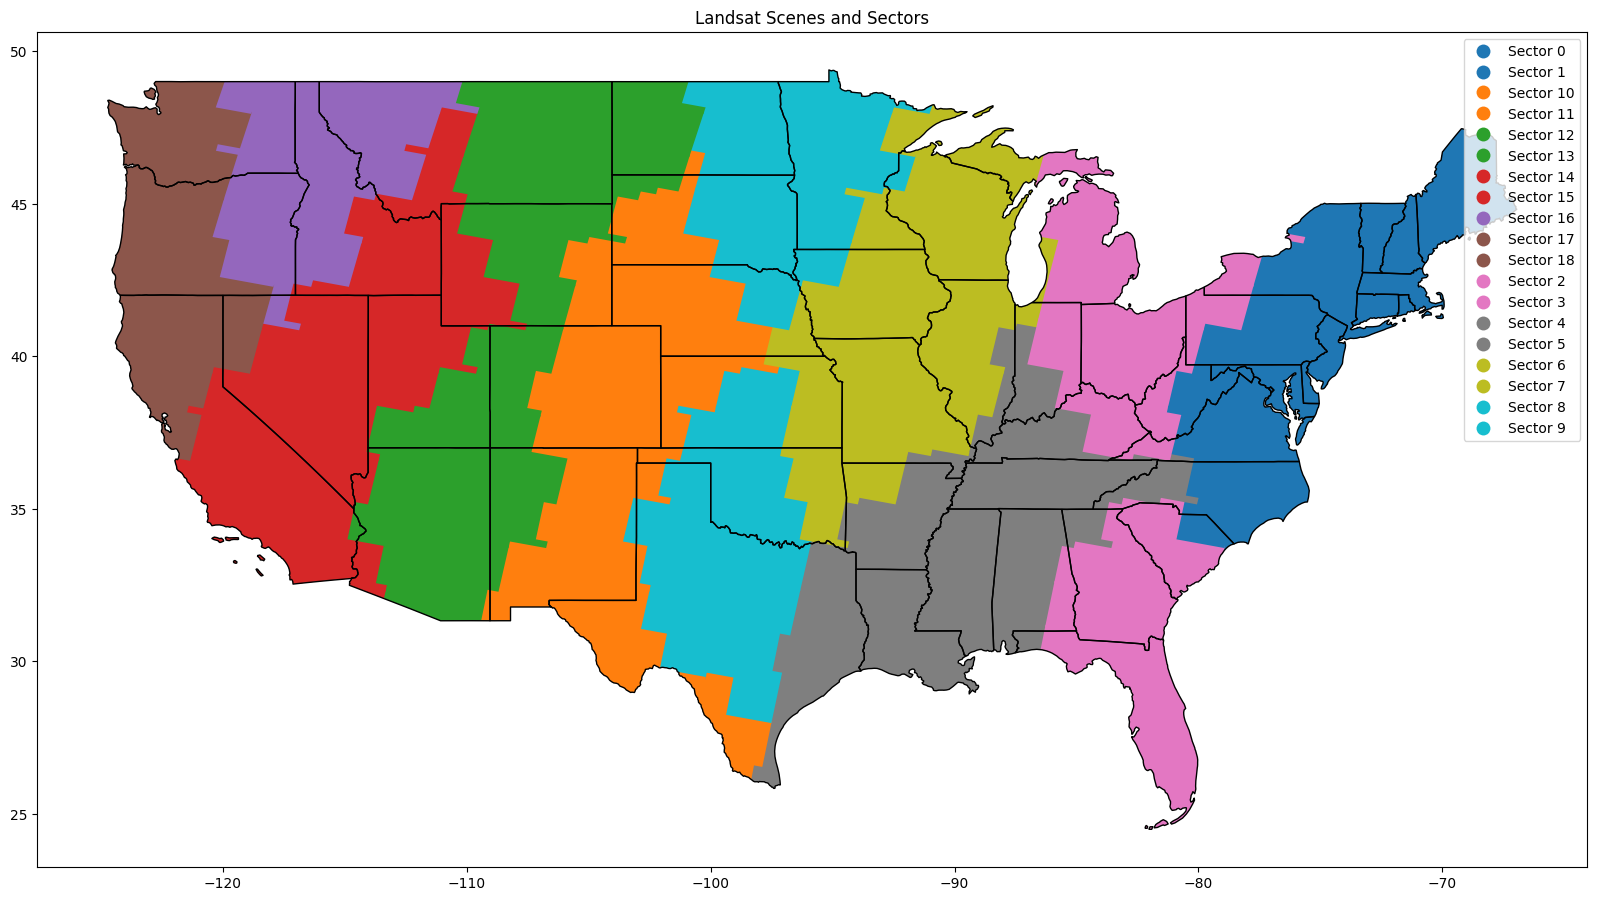

In [164]:
# Plot the States with sectors shown with some transparency
# ax = add_sector_to_scene.plot(column="Sector", figsize=(20, 20), alpha=0.5, legend=True)
# Plot the States with some transparency and dark borders.

ax = add_sector_to_scene.plot(column="Sector", legend=True, figsize=(20, 20))
us_states_continential.plot(ax=ax, color="none", edgecolor="black", linewidth=1)
plt.title("Landsat Scenes and Sectors")

